# Problema 1: Clasificación de audio

Importamos algunas librerías

In [1]:
import numpy as np

## 0. Procesamiento de audio

En primera instancia montamos el drive donde tenemos nuestro dataset.

In [2]:
#montar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = "drive/MyDrive/Datasets/dataset_reducido"
SPANISH_DATA = os.path.join(DATASET_ROOT, "español")
FRENCH_DATA = os.path.join(DATASET_ROOT, "frances")
ENGLISH_DATA = os.path.join(DATASET_ROOT, "ingles")
JAPANESE_DATA = os.path.join(DATASET_ROOT, "japones")

In [4]:
# Escuchamos el fichero de audio que vamos a cargar en el contexto de Jupyter Notebook
import IPython.display as ipd

ipd.Audio(os.path.join(SPANISH_DATA, "1007153953391704970.wav"))

In [85]:
# Cargamos el audio mediante la librería librosa
import librosa

wav, sr = librosa.load(os.path.join(SPANISH_DATA, "1007153953391704970.wav"), sr = None)

In [86]:
from IPython.display import display, Audio

display(Audio(wav, rate=sr))

In [87]:
print(wav)

[0. 0. 0. ... 0. 0. 0.]


In [89]:
print(len(wav)/sr, " segundos")

20.46  segundos


La tasa de muestreo es muy importante, y la usaremos más adelante en diferentes algoritmos. Generalmente se expresa en hercios (Hz), es decir, el número de puntos (muestras) por segundo.

En nuestro ejemplo, sr=22050 por lo que tenemos 22050 muestras por segundo, por lo tanto, podemos calcular la longitud del audio de la siguiente forma:

In [90]:
# Con la tasa de muestreo y el tamaño total de la señal se puede calcular la longitud del audio
long_audio = len(wav)/sr
print("La longitud del audio en segundos es:", long_audio)

La longitud del audio en segundos es: 20.46


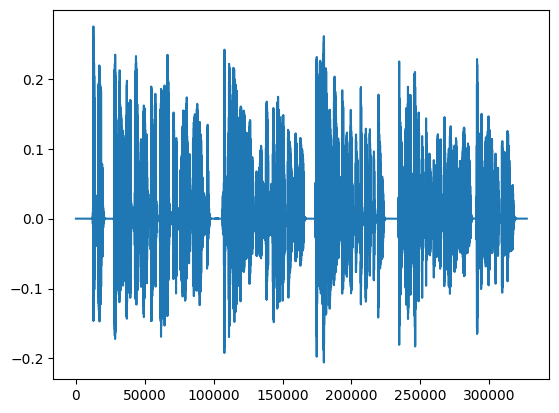

In [91]:
# Representación gráfica de la onda de sonido
from matplotlib import pyplot as plt

plt.plot(wav)
plt.show()

In [92]:
wav, sr = librosa.load(os.path.join(SPANISH_DATA, "1007153953391704970.wav"), sr=None)

In [93]:
print("Tasa de muestreo: {} Hz".format(sr))

Tasa de muestreo: 16000 Hz


### Longitud de los audios

Analicemos la longitud de los distintos audios.

In [94]:
audios = []
audios_failed = []
for data in [SPANISH_DATA, FRENCH_DATA, ENGLISH_DATA, JAPANESE_DATA]:
  for fname in os.listdir(data):
    try:
      wav, sr = librosa.load(os.path.join(data, fname), sr=None)
      audios.append(wav)
    except:
      print("\nError en el fichero: ", fname)
      audios_failed.append(fname)

min_duration = float("inf")
max_duration = 0
for audio in audios:
  if len(audio)/sr < min_duration:
    min_duration = len(audio)/sr
  if len(audio)/sr > max_duration:
    max_duration = len(audio)/sr


print("\nEl audio con duracion minima dura: ", min_duration, " segundos.")
print("El audio con duracion maxima dura: ", max_duration, " segundos.")

<ipython-input-94-52201bc5f57c>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(os.path.join(data, fname), sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



Error en el fichero:  206014402091929850.wav

El audio con duracion minima dura:  4.14  segundos.
El audio con duracion maxima dura:  23.04  segundos.


Esta advertencia:
> ```<ipython-input-50-5f844234ff7c>:5: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(os.path.join(FRENCH_DATA, fname), sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)```

 aparece al querer cargar un formato mp3. Librosa intenta usar libsndfile primero y, si eso falla, recurrirá al paquete audioread, que es un poco más lento, pero admite más formatos.

Tenemos el problema de una **longitud variable** en los audios. Hay varias maneras de abordarlo, sin embargo decidimos rellenar los audios cortos con silencio con el objetivo de no perder información.

### Adaptación de los audios de longitud variable

Utilizaremos numpy y su funcionalidad ```pad``` para rellenar los audios cortos.

In [95]:
longitudes = []

for audio in audios:
  longitudes.append(len(audio)/16000)

In [96]:
np.mean(longitudes)
np.median(longitudes)

10.62

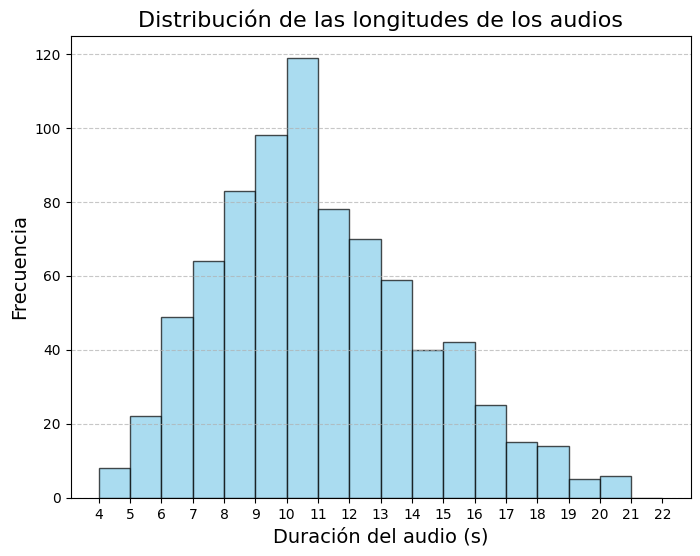

In [97]:
bins = range(int(np.min(longitudes)), int(np.max(longitudes)))  # Incluye desde 4 hasta 20

# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(longitudes, bins=bins, edgecolor='black', color='skyblue', alpha=0.7)

# Etiquetas y título
plt.title('Distribución de las longitudes de los audios', fontsize=16)
plt.xlabel('Duración del audio (s)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(bins)  # Mostrar cada duración en el eje x

# Mostrar la gráfica
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Al observar la distribución de las longitudes o duraciones de los audios, observamos que la mayoría de los audios se encuentra en longitudes centrales que van desde aproximadamente los 7 segundos hasta los 16 segundos, por lo que no consideramos que sea conveniente simplemente extender los audios menores al maximo (22 segundos) con silencio, ya que la mayoría de cada audio quedaría en silencio.


**Análisis de la normalidad de la distribución**

Con el objetivo de quedarnos con la mayoría de los datos, se nos ocurrió analizar la normalidad de la distribución, ya que si las longitudes se distribuyen normal implicaría que dos desviaciones stándard contendrían el 95% de los datos.

Shapiro-Wilk Test: Estadístico=0.9781, p-valor=0.0000
D'Agostino-Pearson Test: Estadístico=37.3919, p-valor=0.0000
Se rechaza la hipótesis nula: los datos no siguen una distribución normal.


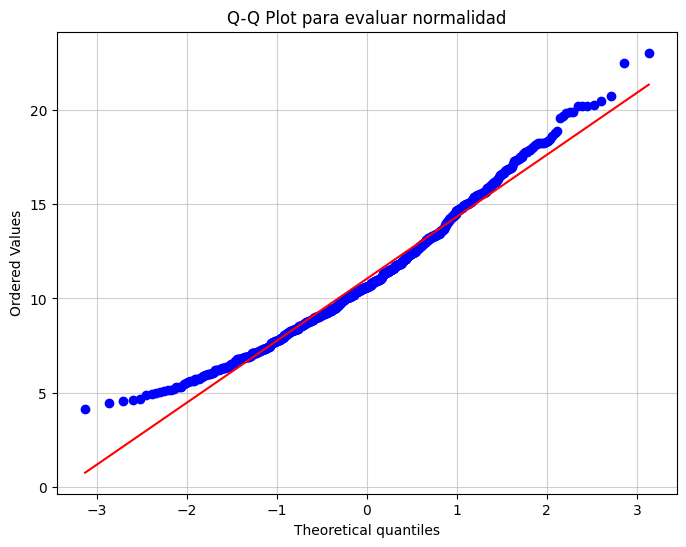

In [98]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Supongamos que tienes las longitudes como una lista
longitudes2 = longitudes  # Reemplaza con tu lista de datos

# --- PRUEBAS DE NORMALIDAD ---
# Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(longitudes2)

# D'Agostino-Pearson Test
dagostino_stat, dagostino_p = stats.normaltest(longitudes2)

# --- IMPRIMIR RESULTADOS ---
print(f"Shapiro-Wilk Test: Estadístico={shapiro_stat:.4f}, p-valor={shapiro_p:.4f}")
print(f"D'Agostino-Pearson Test: Estadístico={dagostino_stat:.4f}, p-valor={dagostino_p:.4f}")

if shapiro_p > 0.05 and dagostino_p > 0.05:
    print("No se rechaza la hipótesis nula: los datos son consistentes con una distribución normal.")
else:
    print("Se rechaza la hipótesis nula: los datos no siguen una distribución normal.")

# --- Q-Q PLOT ---
plt.figure(figsize=(8, 6))
stats.probplot(longitudes2, dist="norm", plot=plt)
plt.title("Q-Q Plot para evaluar normalidad")
plt.grid(alpha=0.6)
plt.show()



Sin embargo, con el Q-Q Plot y un p-value menor a 0.05 concluimos que no es el caso.

**Análisis con gráfico de Paretto**

Como alternativa, realizaremos el análisis de las longitudes con un gráfico de Paretto que nos permita observar en qué rango se encuentra la mayoría de los datos.

In [99]:
import pandas as pd

bins = range(int(np.min(longitudes)), int(np.max(longitudes)))  # De 4 a 20 segundos
hist, edges = np.histogram(longitudes, bins=bins)

df = pd.DataFrame({'longitudes':longitudes})
df['longitudes_discretizadas'] = pd.cut(df['longitudes'], bins=bins, include_lowest=True)

In [100]:
# Contar la frecuencia de aparición de cada intervalo
frequency = df['longitudes_discretizadas'].value_counts().sort_index(ascending=False)
#ordenar frecuency por count
frequency = frequency.sort_values(ascending=False)

<ipython-input-110-58b40e3ee291>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


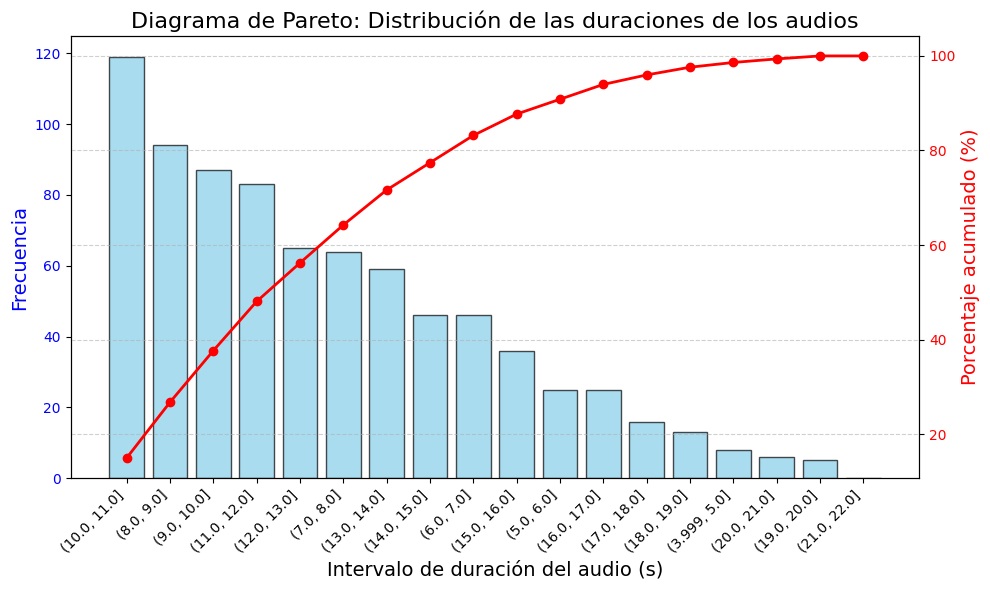

In [110]:
# Contar la frecuencia de aparición de cada intervalo
#frequency = df['longitudes_discretizadas'].value_counts().sort_index(ascending=False)

# Calcular el porcentaje acumulado
cumulative_percentage = np.cumsum(frequency) / frequency.sum() * 100

# Crear el gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras (frecuencia)
ax1.bar(frequency.index.astype(str), frequency, width=0.8, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Intervalo de duración del audio (s)', fontsize=14)
ax1.set_ylabel('Frecuencia', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Gráfico de línea (porcentaje acumulado)
ax2 = ax1.twinx()
ax2.plot(frequency.index.astype(str), cumulative_percentage, color='red', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Porcentaje acumulado (%)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título y configuración
plt.title('Diagrama de Pareto: Distribución de las duraciones de los audios', fontsize=16)
plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Observamos que más del 80% de los audios tiene una duración entre **6 segundos y 15 segundos**. Por este motivo, nos quedaremos con solo estos audios y, para normalizar su duración, **llenaremos los segundos que falte con silencio**.

### Filtrado de audios y division en train y test

A continuación, nos quedamos solo con los audios que tienen una longitud de entre 6 y 15 segundos.

In [111]:
audios = []
categorias = []
audios_failed = []
for data in [SPANISH_DATA, FRENCH_DATA, ENGLISH_DATA, JAPANESE_DATA]:
  for fname in os.listdir(data):
    try:
      wav, sr = librosa.load(os.path.join(data, fname), sr=None)
      if data == SPANISH_DATA:
        audios.append(wav)
        categorias.append("español")
      elif data == FRENCH_DATA:
        audios.append(wav)
        categorias.append("frances")
      elif data == ENGLISH_DATA:
        audios.append(wav)
        categorias.append("ingles")
      else:
        audios.append(wav)
        categorias.append("japones")
    except:
      print("\nError en el fichero: ", fname)
      audios_failed.append(fname)

<ipython-input-111-6dd11719b4c0>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(os.path.join(data, fname), sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



Error en el fichero:  206014402091929850.wav


In [112]:
df_audios = pd.DataFrame(zip(audios, categorias), columns = ['audio', 'idioma'])

In [113]:

audios_filtered = []
for audio in audios:
  if len(audio)/16000 >= 6 and len(audio)/16000 <= 15:
    audios_filtered.append(audio)

print("Nos quedamos con el ", round(len(audios_filtered)/len(audios)*100, 2), "% de los audios.")

Nos quedamos con el  83.35 % de los audios.


In [114]:
df_audios['duracion'] = df_audios['audio'].apply(lambda x: len(x)/16000)
df_audios

audio   idioma  duracion
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  español     12.24
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  español      7.92
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  español      8.76
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  español      6.90
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  español     16.26
..                                                 ...      ...       ...
794  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  japones      7.08
795  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  japones     14.28
796  [0.0, 0.0, -3.0517578e-05, -3.0517578e-05, -3....  japones     19.56
797  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  japones     13.32
798  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  japones     13.44

[799 rows x 3 columns]

In [115]:
df_filtered = df_audios[(df_audios['duracion'] >= 6) & (df_audios['duracion'] <= 15)]

In [116]:
proporcion = len(df_filtered.audio)/len(df_audios.audio)

print("Nos quedamos con el ", round(proporcion*100, 2), "% de los audios.")

Nos quedamos con el  83.35 % de los audios.


In [117]:
X = df_filtered.audio.to_list()
y = df_filtered.idioma

### Añadir padding a los audios

Como se comentó anteriormente, los audios tienen longitud variable. Por ello, se le agregará padding de silencio.

In [118]:
X[0].shape[0]/sr

12.24

In [119]:
audios = X
max_length = 16*16000 #16 segundos por los 16000 mhz

# Añadir padding a los audios más cortos
audios_padded = []
for audio in audios:
    if len(audio) < max_length:
        audio = np.pad(audio, (0, max_length - len(audio)), mode='constant')
    audios_padded.append(audio)

In [120]:
#Comprobamos que todos tengan la misma longitud
for i in audios_padded:
  if len(i) != 16*16000:
    print(len(i))

In [121]:
X_padded = audios_padded

### Convertir a espectograma

Usamos la función definida en el lab 11 para pasar de una waveform a un espectograma.

In [122]:
import tensorflow as tf

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Nuestro primer ejemplo pasado a espectograma queda con un shape igual a (1999,129,1)

In [123]:
get_spectrogram(X_padded[0])

<tf.Tensor: shape=(1999, 129, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

Utilizamos también la función definida en clase para graficar los espectogramas:

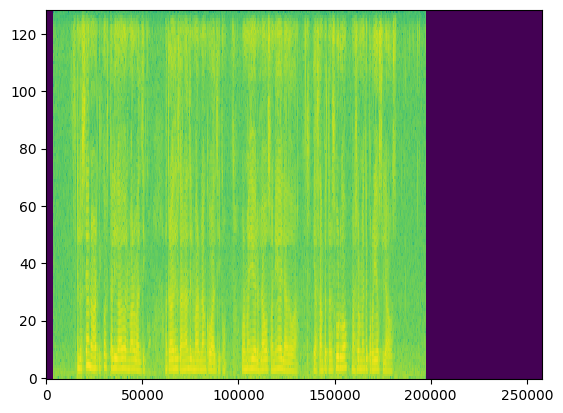

In [124]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

plot_spectrogram(get_spectrogram(X_padded[0]), plt)

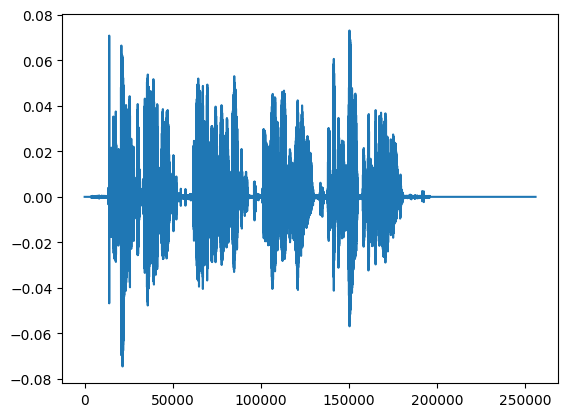

In [125]:
plt.plot(X_padded[0])

Una vez visualizadas algunas comparaciones de cómo quedarían nuestros audios, pasamos todos los audios de X_padded a espectogramas.

In [126]:
X_spectrogram = []
for audio in X_padded:
  X_spectrogram.append(get_spectrogram(audio))

type(X_spectrogram)

list

In [127]:
X = np.array(X_spectrogram)

Listo, ya tenemmos lista nuestro conjunto X.

### Preparar o codear variable target

Actualmente, nuestra variable target tiene la siguiente forma:

In [128]:
type(y)

pandas.core.series.Series

No siendo apropiado este formato para ser pasado a una red neuronal.

In [129]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Paso 1: Convertir las categorías en números enteros
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Paso 2: Convertir los números en codificación one-hot
one_hot_encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False para obtener un array denso
y_one_hot = one_hot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# Resultado
print("Categorías asignadas por LabelEncoder:", label_encoder.classes_)
print("Codificación numérica:", y_encoded)
print("Codificación one-hot:\n", y_one_hot)

Categorías asignadas por LabelEncoder: ['español' 'frances' 'ingles' 'japones']
Codificación numérica: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

Utilizaremos el formato de codificación numérica.

## 1. Preparación del conjunto de datos

In [130]:
print("La longitud del conjunto de datos es: ", len(X_padded))

La longitud del conjunto de datos es:  666


De manera empírica y luego de ver un rendimiento deficiente en la RNN, se descrubrió que algunos audios conservan demasiado ruido en ellos.

español


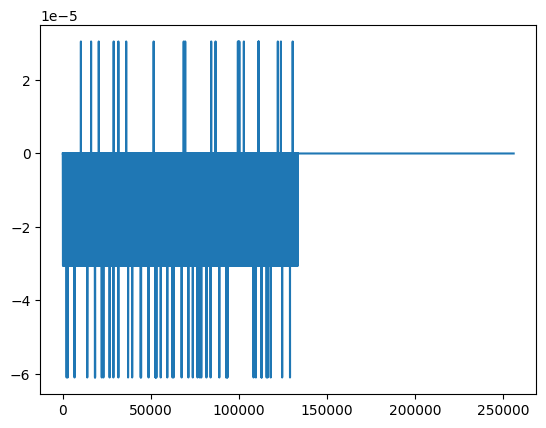

In [131]:
from IPython.display import display, Audio

display(Audio(X_padded[123], rate=16000))
print(y[123])
plt.plot(X_padded[123])

El Spectral contrast considera los picos espectrales, y los ‘valles’ espectrales, y sus diferencias en cada subbanda de frecuencia.

Un valor bajo del contraste espectral podría significar que el audio solo contiene ruido.

Para calcular el spectral contrast para seis subbandas para cada segmento se puede usar ```librosa.feature.spectral_contrast```

In [132]:
import librosa.feature

# Calcular contraste espectral
contrast = librosa.feature.spectral_contrast(y=X_padded[123], sr=sr)
avg_contrast = np.mean(contrast, axis=1)
median_contrast = np.median(contrast, axis=1)
print(f"Contraste espectral promedio: {avg_contrast.mean()}")
print(f"Contraste espectral mediano: {median_contrast.mean()}")

contrast = librosa.feature.spectral_contrast(y=X_padded[0], sr=sr)
avg_contrast = np.mean(contrast, axis=1)
print(f"Contraste espectral promedio: {avg_contrast.mean()}")
median_contrast = np.median(contrast, axis=1)
print(f"Contraste espectral mediano: {median_contrast.mean()}")


Contraste espectral promedio: 8.649055970325204
Contraste espectral mediano: 11.65239203793236
Contraste espectral promedio: 19.363249917129668
Contraste espectral mediano: 19.334556730180132


In [133]:
audios_with_noise = []
audios_without_noise = []
for i, audio in enumerate(X_padded):
  contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
  avg_contrast = np.mean(contrast, axis=1)
  if avg_contrast.mean() < 12: #umbral definido empiricamente
    audios_with_noise.append((i, audio))
  else:
    audios_without_noise.append(audio)
print("Se agregaron ", len(audios_with_noise), " audios con ruido.")
print("Se conservaron ", len(audios_without_noise), " audios sin ruido.")

Se agregaron  22  audios con ruido.
Se conservaron  644  audios sin ruido.


Empiricamente se comprobo que un umbral de 12 extrae unicamente audios con ruido.

In [134]:
index = 21
print("Pertenece a la clase: ", y[audios_with_noise[index][0]])
Audio(audios_with_noise[index][1], rate=16000)

Pertenece a la clase:  español


In [135]:
indices = []
for audio in audios_with_noise:
  indices.append(audio[0])

In [136]:
X_without_noise = []

for i, audio in enumerate(X):
  if i not in indices:
    X_without_noise.append(audio)

In [137]:
y_without_noise = []
for i, label in enumerate(y_encoded):
  if i not in indices:
    y_without_noise.append(label)

Nos quedo un ligero desbalanceo en las clases, pero no consideramos que sea de importancia.

Text(0.5, 0, 'Clase')

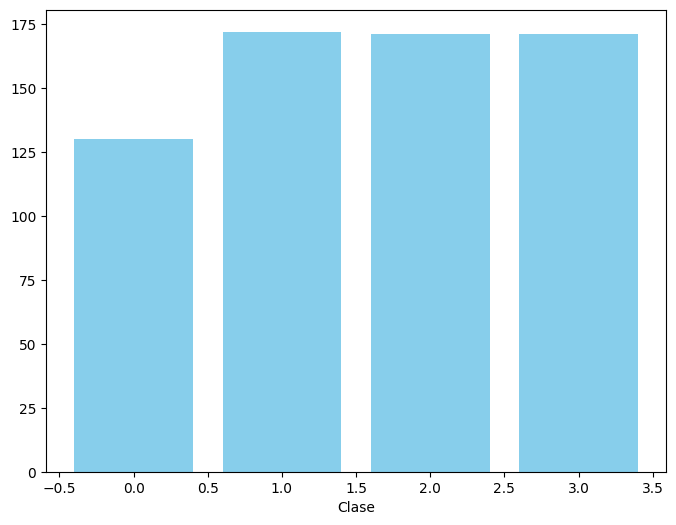

In [138]:
# Contar la frecuencia de aparición de cada clase
class_counts = {label: y_without_noise.count(label) for label in set(y_without_noise)}

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Clase')

In [139]:
y_encoded = np.array(y_without_noise)
X = np.array(X_without_noise)

In [140]:
X.shape

(644, 1999, 129, 1)

## 2. División del conjunto de datos

In [141]:
# Dividimos el conjunto de datos en entrenamiento y pruebas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, np.array(y_encoded), test_size=0.2, shuffle=True)

In [142]:
print("Longitud del subconjunto de entrenamiento: ", len(X_train))
print("Longitud del subconjunto de pruebas: ", len(X_test))

Longitud del subconjunto de entrenamiento:  515
Longitud del subconjunto de pruebas:  129


## 3. Construcción del modelo

Una vez más, comprobamos las longitudes homogeneas en los audios.

In [143]:
print(len(X_train[0]))
print(len(X_train[54]))

1999
1999


Vemos que todos tienen la misma longitud

In [144]:
display(Audio(X_padded[54], rate=16000))
display(Audio(X_padded[105], rate=16000))
display(Audio(X_padded[200], rate=16000))

### Red recurrente

In [145]:
X_train[0].shape

(1999, 129, 1)

In [146]:
X_train.shape

(515, 1999, 129, 1)

In [147]:
# Fragmentar espectrogramas y transformar para una RNN
def process_for_rnn(X_train, fragment_length=500):
    X_train_rnn = []
    for spectrogram in X_train:
        # Remover el canal extra (ajustar de (1999, 129, 1) a (1999, 129))
        spectrogram = spectrogram.squeeze(-1)

        # Dividir el espectrograma en fragmentos de longitud 500
        num_fragments = spectrogram.shape[0] // fragment_length
        for i in range(num_fragments):
            fragment = spectrogram[i * fragment_length:(i + 1) * fragment_length, :]
            X_train_rnn.append(fragment)

    # Convertir la lista final a un array de NumPy
    return np.array(X_train_rnn)

# Aplicar la transformación
X_train_rnn = process_for_rnn(X_train)

# Verificar dimensiones finales
print(f"Forma original de X_train: {X_train.shape}")
print(f"Nueva forma de X_train_rnn: {X_train_rnn.shape}")



Forma original de X_train: (515, 1999, 129, 1)
Nueva forma de X_train_rnn: (1545, 500, 129)


In [148]:
y_train.shape

(515,)

Adaptamos y_train

In [149]:
# Ajustar etiquetas para coincidir con los fragmentos de X_train_rnn
def adjust_labels(y_train, num_fragments=3):
    y_train_rnn = []
    for label in y_train:
        # Repetir la etiqueta tantas veces como fragmentos por audio
        y_train_rnn.extend([label] * num_fragments)
    return np.array(y_train_rnn)

# Aplicar ajuste
y_train_rnn = adjust_labels(y_train, num_fragments=1999 // 500)

# Verificar dimensiones finales
print(f"Forma original de y_train: {y_train.shape}")
print(f"Forma ajustada de y_train_rnn: {y_train_rnn.shape}")


Forma original de y_train: (515,)
Forma ajustada de y_train_rnn: (1545,)


In [150]:
X_train_rnn[0].shape[1]

129

In [151]:
#prueba sin adaptar los audios
# X_train_rnn = X_train
# y_train_rnn = y_train

In [152]:
X_train_rnn[0].shape

(500, 129)

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Dimensiones del espectrograma Mel
timesteps = X_train_rnn[0].shape[0]  # Frames temporales
features = X_train_rnn[0].shape[1]  # Bandas Mel (características)

# Crear el modelo
model = Sequential([
    # Capa convolucional para capturar patrones locales en las bandas Mel
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, features)),
    MaxPooling1D(pool_size=3),  # Reducción de la dimensionalidad en el eje temporal
    Dropout(0.5),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dropout(0.5),

    # Conv1D(filters=256, kernel_size=3, activation='relu'),
    # MaxPooling1D(pool_size=3),
    # Dropout(0.5),

    # Capa LSTM para modelar la secuencia temporal
    LSTM(64, return_sequences=False),  # Procesamiento secuencial
    Dropout(0.5),

    # Capas densas para clasificar
    Dense(32, activation='relu'),
    #Dropout(0.5),
    Dense(4, activation='softmax')  # Salida para 4 clases
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 498, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 166, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 166, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 164, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 54, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 54, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,156 (395.14 KB)

 Trainable params: 101,156 (395.14 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
# Entrenar el modelo
history = model.fit(X_train_rnn, y_train_rnn, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2660 - loss: 1.4019 - val_accuracy: 0.3786 - val_loss: 1.3498
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3914 - loss: 1.3472 - val_accuracy: 0.3560 - val_loss: 1.3268
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3974 - loss: 1.3062 - val_accuracy: 0.4078 - val_loss: 1.3128
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4488 - loss: 1.2229 - val_accuracy: 0.4013 - val_loss: 1.3259
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4802 - loss: 1.1705 - val_accuracy: 0.4725 - val_loss: 1.2367
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5125 - loss: 1.1143 - val_accuracy: 0.4563 - val_loss: 1.2166
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5521 - loss: 1.0521 - val_accuracy: 0.4984 - val_loss: 1.2309
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5640 - loss: 1.0186 - val_accuracy: 0.

In [155]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

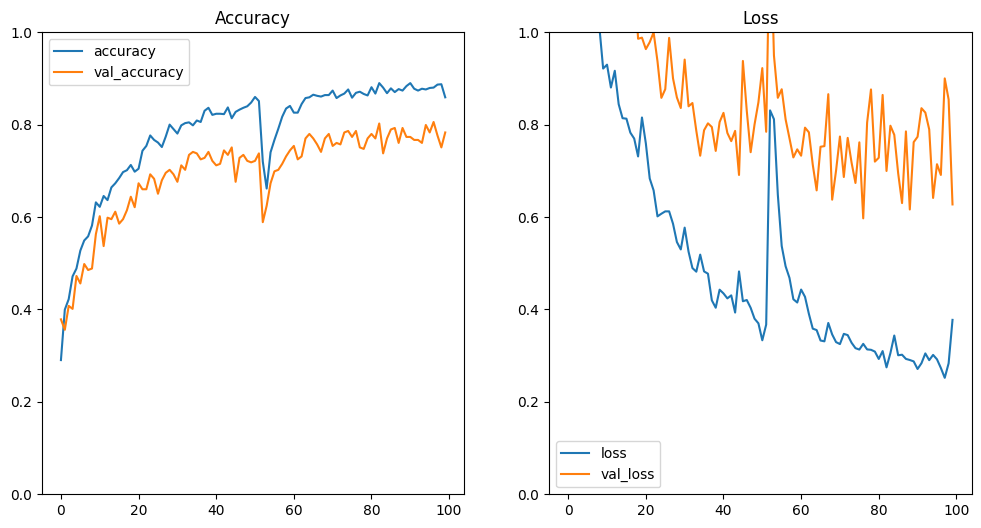

In [156]:
# Crear los gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Accuracy
ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_ylim(0, 1)  # Ajustar la escala del eje Y de 0 a 1

# Gráfico de Loss
ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_ylim(0, 1)  # Ajustar la escala del eje Y de 0 a 1

# Mostrar los gráficos
plt.show()


Preparamos el conjunto test para evaluarlo.

In [157]:
X_test_rnn = process_for_rnn(X_test, 500)
y_test_rnn = adjust_labels(y_test, num_fragments=1999 // 500)

In [158]:
y_test_rnn.shape, X_test_rnn.shape

((387,), (387, 500, 129))

In [159]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_rnn, y_test_rnn, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8290 - loss: 0.4598
Test Loss: 0.5336454510688782
Test Accuracy: 0.8139534592628479


Guardamos el modelo

In [160]:
# Opcional: Guardar en formato HDF5 (archivo único .h5)
#model.save('audioClassifierRNN.h5')

### Red Convolucional

Definimos la arquitectura:

In [161]:
X_train[0].shape

(1999, 129, 1)

In [162]:
mean = X_train.mean()
var = X_train.var()

In [163]:
input_shape = X_train[0].shape

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Resizing, Input, Flatten, Normalization

#Normalizacion
norm_layer = Normalization()

#Aplicar la normalizacion a cada registro
norm_layer.adapt(X_train)

In [164]:

model = Sequential([
    Input(shape=input_shape),
    Resizing(128, 128),
    norm_layer,

    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=3),
    Dropout(0.5),

    Conv2D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=3),
    Dropout(0.5),

    Flatten(),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

# Configura el optimizador Adam con una tasa de aprendizaje personalizada
learning_rate = 0.001  # Cambia este valor según sea necesario
optimizer = Adam(learning_rate=learning_rate)

# Compila el modelo con el optimizador personalizado
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 128, 128, 1)         │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         692,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 766,887 (2.93 MB)

 Trainable params: 766,884 (2.93 MB)

 Non-trainable params: 3 (16.00 B)

In [165]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3109 - loss: 1.7260 - val_accuracy: 0.2718 - val_loss: 1.3358
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.3823 - loss: 1.2664 - val_accuracy: 0.4175 - val_loss: 1.3003
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.3934 - loss: 1.2046 - val_accuracy: 0.4757 - val_loss: 1.2643
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4560 - loss: 1.1335 - val_accuracy: 0.4660 - val_loss: 1.2277
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4893 - loss: 1.0918 - val_accuracy: 0.5243 - val_loss: 1.2277
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5372 - loss: 1.0561 - val_accuracy: 0.4951 - val_loss: 1.1870
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5463 - loss: 1.0210 - val_accuracy: 0.6019 - val_loss: 1.1395
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5676 - loss: 0.9860 - val_accuracy: 0.5631 - val_loss: 1

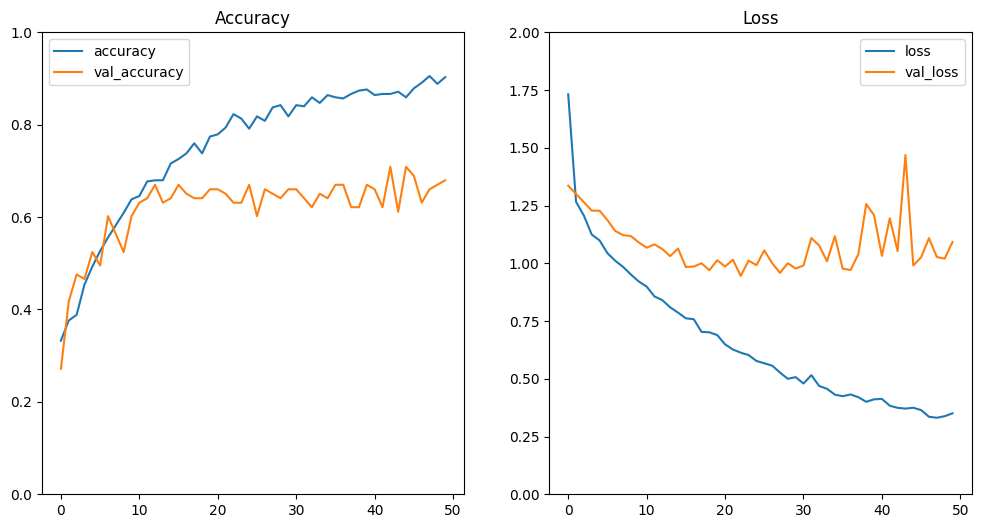

In [166]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear los gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Accuracy
ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_ylim(0, 1)  # Ajustar la escala del eje Y de 0 a 1

# Gráfico de Loss
ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_ylim(0, 2)  # Ajustar la escala del eje Y de 0 a 1

# Mostrar los gráficos
plt.show()


In [169]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.6420 - loss: 1.3373
Test Loss: 1.3098866939544678
Test Accuracy: 0.643410861492157


#Prueba

In [167]:
!pip install pydub

In [168]:
from pydub import AudioSegment

# Cargar el archivo OGG
audio = AudioSegment.from_ogg("audioPrueba.ogg")

# Convertir el audio a WAV y guardar el archivo
audio.export("audio_convertido.wav", format="wav")

print("Conversión completada: audio_convertido.wav")


FileNotFoundError: [Errno 2] No such file or directory: 'audioPrueba.ogg'

In [ ]:
wav, sr = librosa.load('audio_convertido.wav')

In [ ]:
display(Audio(wav, rate=sr))

In [ ]:
spectograma_audio_prueba = process_for_rnn(np.array([get_spectrogram(wav)]))
spectograma_audio_prueba.shape

In [ ]:
# Obtener las predicciones
y_pred_probs = model.predict(spectograma_audio_prueba)  # Probabilidades de las clases
y_pred = y_pred_probs.argmax(axis=1)  # Convertir a etiquetas de clase

# Mostrar las primeras 5 predicciones (opcional)
print("Predicciones:", y_pred[:3])